C:\Users\erlen\AppData\Local\Temp\ipykernel_652\1211686230.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{i}"] = df[col].shift(i)
C:\Users\erlen\AppData\Local\Temp\ipykernel_652\1211686230.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{i}"] = df[col].shift(i)
C:\Users\erlen\AppData\Local\Temp\ipykernel_652\1211686230.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

Linear Regression RMSE: 3.93
Additive Model RMSE: 8.26
SVR RMSE: 3.65
Random Forest RMSE: 32.06
Neural Network RMSE: 5.89


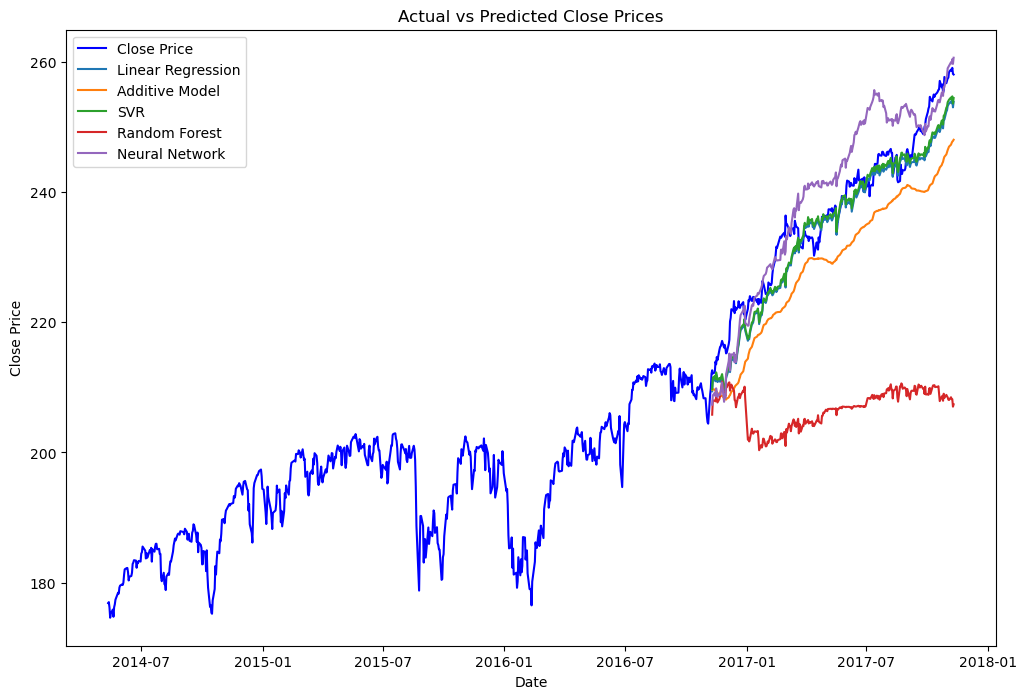

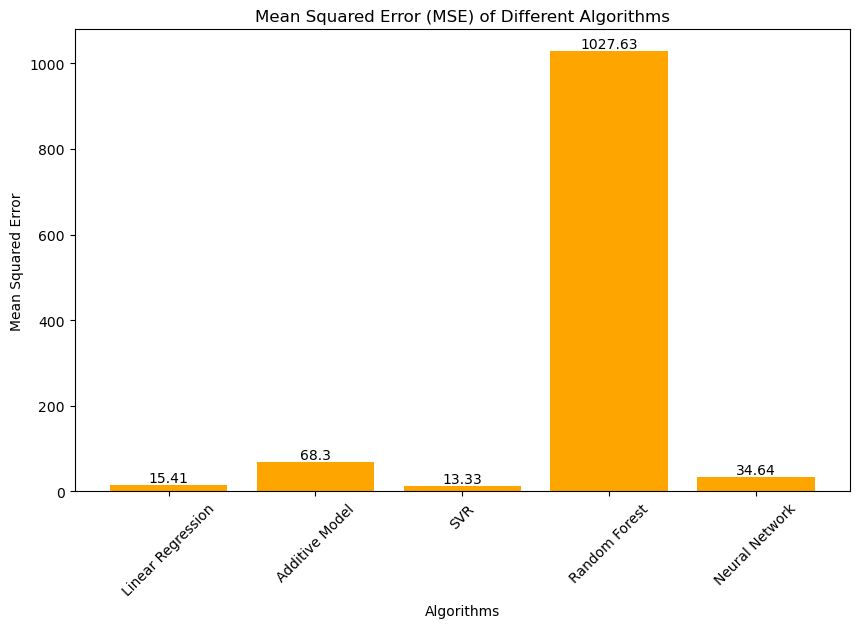

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, LogisticGAM, PoissonGAM, f, s
from sklearn import clone
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE


def create_date_features(df):
    df["DayOfYear"] = df.index.dayofyear
    df["WeekOfYear"] = df.index.isocalendar().week
    df["Month"] = df.index.month
    df["Year"] = df.index.year

    # Sine-cosine encoding for cyclical features
    df["DayOfYear_sin"] = np.sin(2 * np.pi * df["DayOfYear"] / 365.25)
    df["DayOfYear_cos"] = np.cos(2 * np.pi * df["DayOfYear"] / 365.25)
    df["WeekOfYear_sin"] = np.sin(2 * np.pi * df["WeekOfYear"] / 52)
    df["WeekOfYear_cos"] = np.cos(2 * np.pi * df["WeekOfYear"] / 52)
    df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
    df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

    return df


# Load the data
df = pd.read_csv("../../data/stock-market/ETFs/spy.us.txt")

# Convert Date column to datetime and set it as the index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        df[f"{col}_lag_{i}"] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df["Close"]
features = [col for col in df.columns if col != "Close"]
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < start_date]
test_X_normalized = X_normalized[X.index >= start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(
    np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2)
)
n_components = (
    np.argmax(cumulative_variance >= 0.95) + 1
)  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[: len(train_X)]
test_X_pls = X_pls[len(train_X) :]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[: len(train_X)]
test_X_rfe = X_rfe[len(train_X):]
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Additive Model": PoissonGAM(s(0, n_splines=10) + f(1), fit_intercept=True),
    "SVR": SVR(kernel="linear", C=100, epsilon=5),
    # Optimized Random Forest Regressor
    "Random Forest": RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        max_features="sqrt",
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
    ),
    "Neural Network": MLPRegressor(
        hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01
    ),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model="additive", period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions and store MSE values for each model
predictions = {}
mse_values = {}
for name, model in models.items():
    if name == "Linear Regression":
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X) :]
    else:
        model.fit(train_X_rfe, train_y if name == "Additive Model" else train_y)
        pred = model.predict(test_X_rfe)
        if name == "Additive Model":
            model.fit(train_X_rfe, train_y)

    predictions[name] = pred

    # Calculate MSE for each model and store it in mse_values dictionary
    mse_values[name] = mean_squared_error(test_y, pred)

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df["Actual"] = test_y

# Calculate and display RMSE for each model and print MSE values for bar chart plotting
for name in predictions.keys():
    rmse = np.sqrt(mse_values[name])
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(
    df_last_3_years.index, df_last_3_years["Close"], label="Close Price", color="blue"
)

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
bars = plt.bar(list(mse_values.keys()), list(mse_values.values()), color="orange")

plt.title("Mean Squared Error (MSE) of Different Algorithms")
plt.ylabel("Mean Squared Error")
plt.xlabel("Algorithms")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
    )  # Position the text at the center of the bar and just above it

plt.show()

In [83]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

boostpred = {}
boostmse = {}

# Loop through each model in the models dictionary and apply AdaBoost
for name, model in models.items():
    # Skip Additive Model (if you don't want it boosted)
    if name == "Additive Model":
        continue

    # Use AdaBoost with the current model as the base estimator
    boosted_model = AdaBoostRegressor(
        estimator=model, n_estimators=50, random_state=42
    )
    
    # Fit the boosted model on the training data
    boosted_model.fit(train_X_rfe, train_y)

    # Make predictions on the test set
    pred = boosted_model.predict(test_X_rfe)

    # Store predictions and MSE for each boosted model
    boostpred["Boosting " + name] = pred
    boostmse["Boosting " + name] = mean_squared_error(test_y, pred)

# Calculate and display RMSE for each boosted model
for name in boostpred.keys():
    rmse = np.sqrt(boostmse[name])
    print(f"{name} RMSE: {rmse:.2f}")

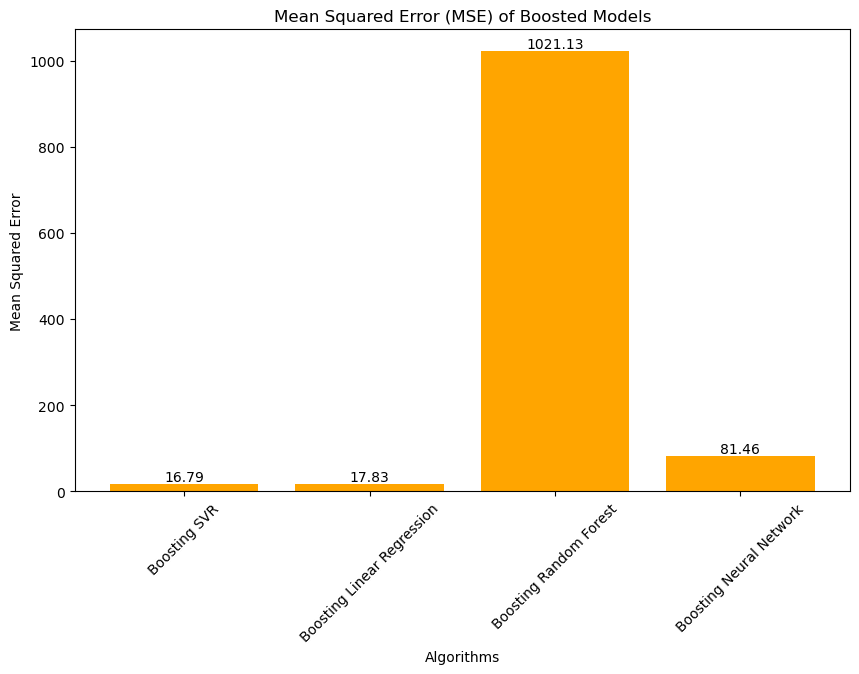

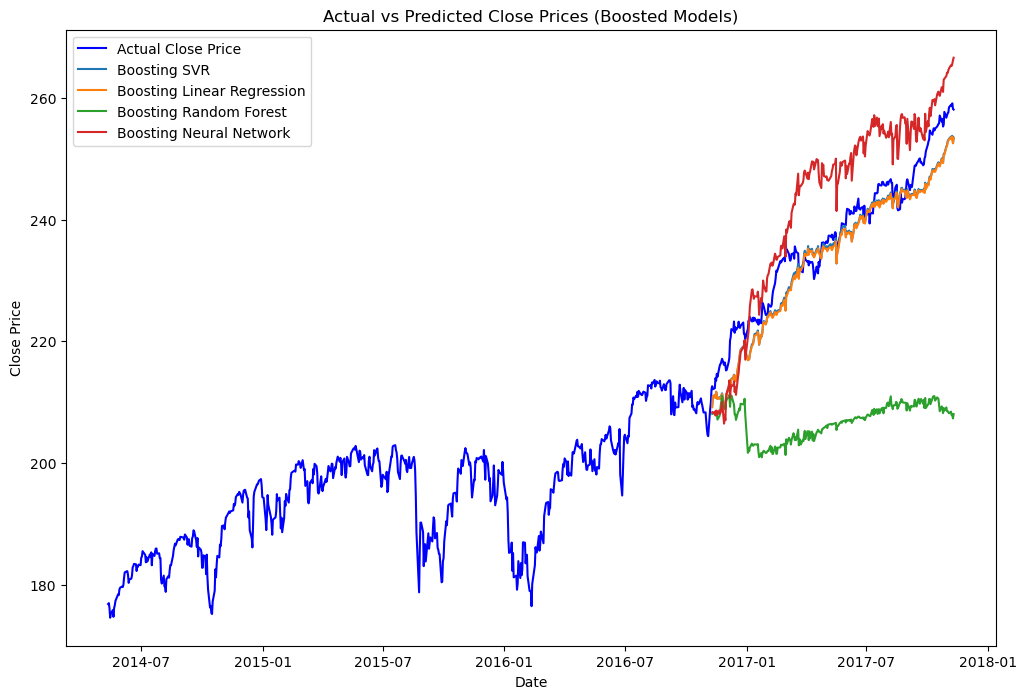

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Plot MSE values for Boosted models
plt.figure(figsize=(10, 6))
bars = plt.bar(list(boostmse.keys()), list(boostmse.values()), color="orange")

plt.title("Mean Squared Error (MSE) of Boosted Models")
plt.ylabel("Mean Squared Error")
plt.xlabel("Algorithms")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
    )  # Position text at center of bar

plt.show()

# Plot Actual vs Predicted Prices (Boosted models)
plt.figure(figsize=(12, 8))

# Plot actual close price
plt.plot(df_last_3_years.index, df_last_3_years["Close"], label="Actual Close Price", color="blue")

# Plot predictions from each boosted model
for name, pred in boostpred.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices (Boosted Models)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


C:\Users\erlen\AppData\Local\Temp\ipykernel_652\3447319848.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="best")


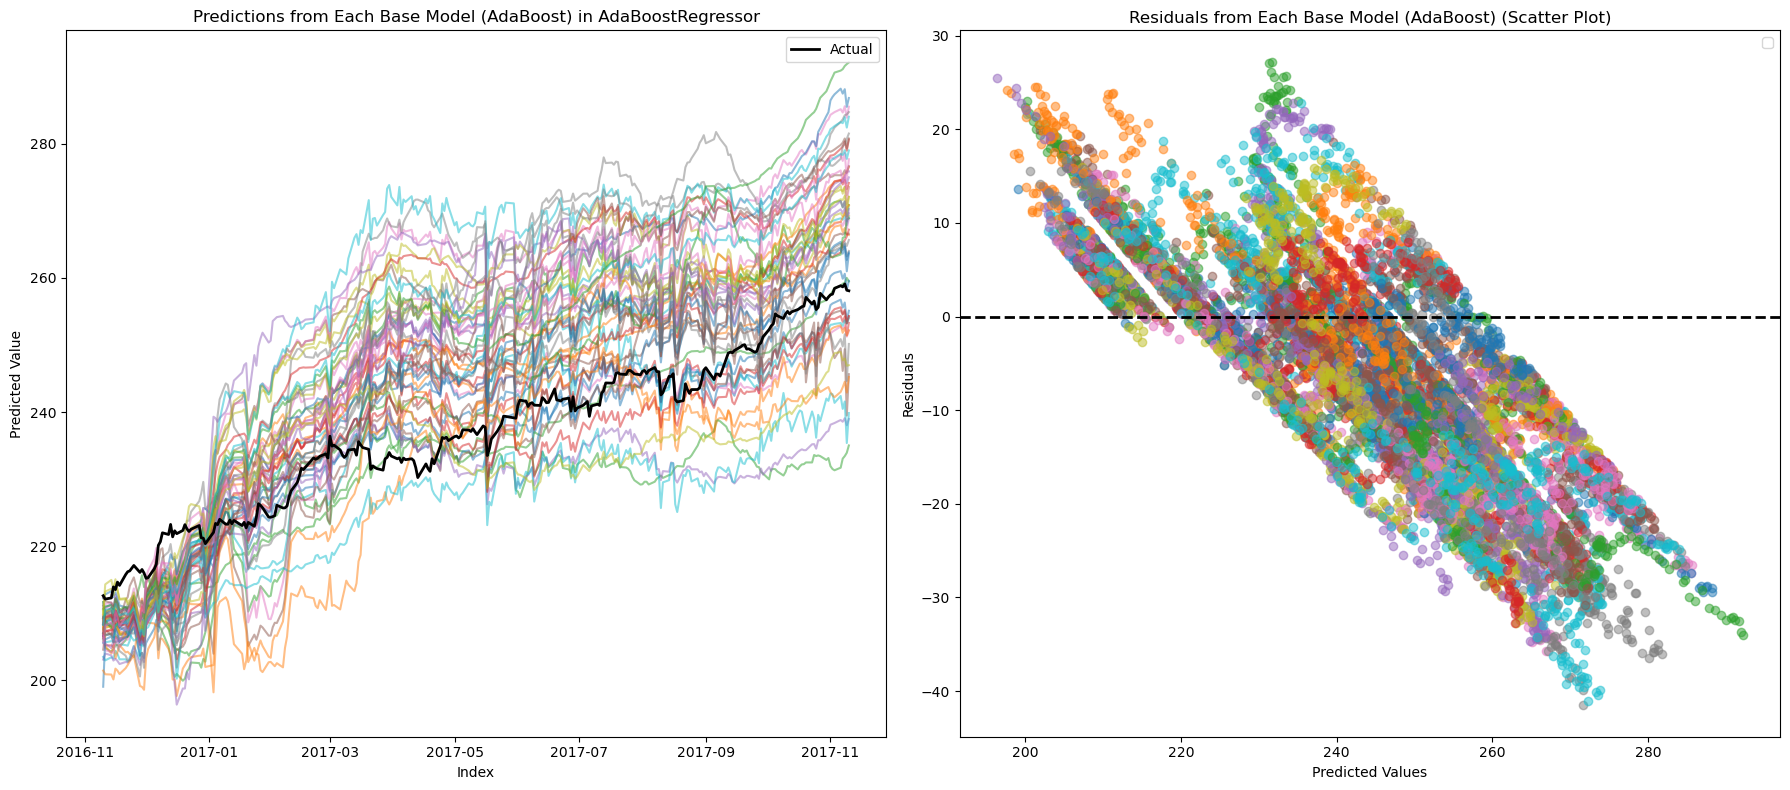

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming AdaBoostRegressor is already trained with base models (like SVR, etc.)
# Get predictions from each base model (estimators) in the AdaBoostRegressor
base_model_predictions_boosting = np.array([estimator.predict(test_X_rfe) for estimator in boosted_model.estimators_])

# List of base model names for boosting (you can customize this)
base_model_names_boosting = ["SVR"] * len(boosted_model.estimators_)  # Example for SVR, adjust for your base models

# Create a figure with 2 subplots: one for predictions and one for residuals (scatter plot)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot patterns (predictions) from each base model
for i, pred in enumerate(base_model_predictions_boosting):
    axes[0].plot(test_y.index, pred,  alpha=0.5)

axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
axes[0].set_title("Predictions from Each Base Model (AdaBoost) in AdaBoostRegressor")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Predicted Value")
axes[0].legend(loc="best")

# Plot residuals as scatter plots for each base model
for i, pred in enumerate(base_model_predictions_boosting):
    residuals = test_y - pred
    axes[1].scatter(pred, residuals, alpha=0.5)

axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title("Residuals from Each Base Model (AdaBoost) (Scatter Plot)")
axes[1].set_xlabel("Predicted Values")
axes[1].set_ylabel("Residuals")
axes[1].legend(loc="best")

# Show the side-by-side plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import BaggingRegressor
# Initialize dictionaries to store bagged predictions and MSE values
bagpred = {}
bagmse = {}

# Loop through each model in the models dictionary
for name, model in models.items():
    if name == "Linear Regression":
        # For Linear Regression, we can directly bag it
        bagging_model = BaggingRegressor(
            estimator=model,  # Use Linear Regression as the base estimator
            n_estimators=50,  # Number of base estimators
            random_state=42,
        )
        bagging_model.fit(train_X_rfe, train_y)  # Fit on training data

        # Generate predictions on test set
        pred = bagging_model.predict(test_X_rfe)

    elif name == "Additive Model":
        continue
                # Ensure Additive Model is compatible
        bagging_model = BaggingRegressor(
            estimator= model,  # Use Additive Model as the base estimator
            n_estimators=50,  # Number of base estimators
            random_state=42,
            n_jobs=-1  # Use all CPU cores for parallel processing
        )
        bagging_model.fit(train_X_rfe, train_y)  # Fit on training data

    else:
        # For other models, wrap them in a Bagging Regressor
        bagging_model = BaggingRegressor(
            estimator=model,  # Base estimator
            n_estimators=50,  # Number of base estimators
            random_state=42,
        )
        bagging_model.fit(train_X_rfe, train_y)  # Fit on training data

        # Generate predictions on test set
        pred = bagging_model.predict(test_X_rfe)

    # Store predictions and MSE values for each bagged model
    bagpred["Bagging " + name] = pred
    bagmse["Bagging " + name] = mean_squared_error(test_y, pred)

# Calculate and display RMSE for each bagged model
for name in bagpred.keys():
    rmse = np.sqrt(bagmse[name])
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices including Bagged Linear Regression model
plt.figure(figsize=(12, 8))
plt.plot(
    df_last_3_years.index, df_last_3_years["Close"], label="Close Price", color="blue"
)

# Plot each model's predictions including Bagged models
for name, pred in bagpred.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices (Bagged Models)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot MSE values for Bagged models
plt.figure(figsize=(10, 6))
bars = plt.bar(list(bagmse.keys()), list(bagmse.values()), color="orange")

plt.title("Mean Squared Error (MSE) of Bagged Algorithms")
plt.ylabel("Mean Squared Error")
plt.xlabel("Algorithms")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
    )  # Position text at center of bar

plt.show()

RuntimeError: Cannot clone object LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False), as the constructor either does not set or modifies parameter callbacks

C:\Users\erlen\AppData\Local\Temp\ipykernel_652\2472514153.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="best")


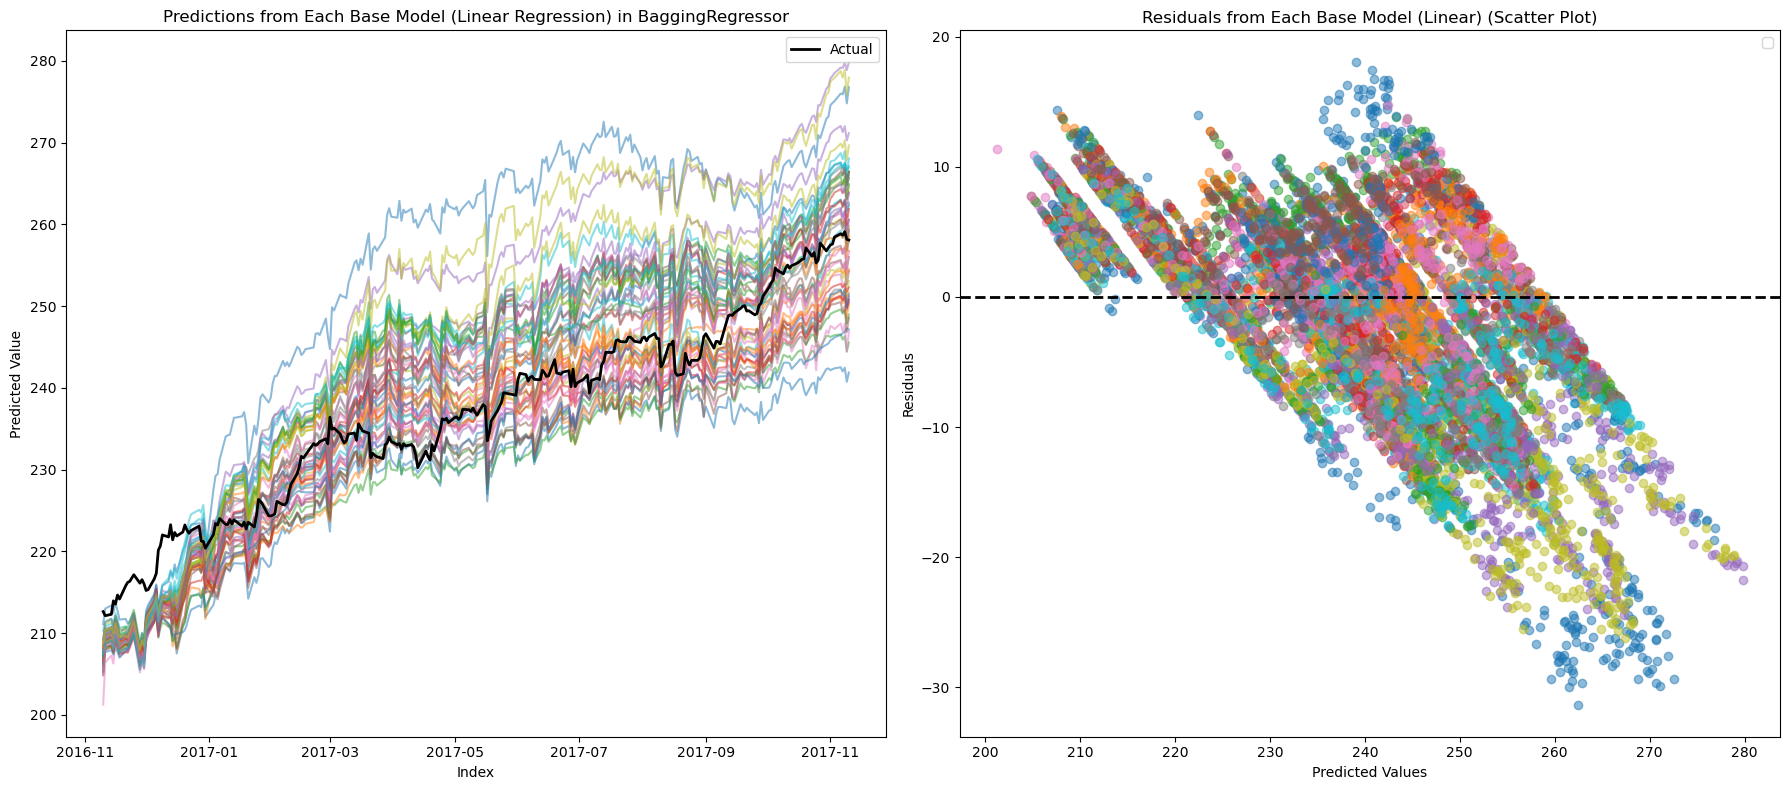

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Assuming `bagging_model` is already trained with base estimators like Linear Regression
# Get predictions from each base model (estimators)
base_model_predictions = np.array([estimator.predict(test_X_rfe) for estimator in bagging_model.estimators_])

# List of base model names (you can customize this based on your actual models)
base_model_names = ["Linear Regression"] * len(bagging_model.estimators_)  # Example for Linear Regression

# Create a figure with 2 subplots: one for predictions and one for residuals (scatter plot)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot patterns (predictions) from each base model
for i, pred in enumerate(base_model_predictions):
    axes[0].plot(test_y.index, pred,  alpha=0.5)

axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
axes[0].set_title("Predictions from Each Base Model (Linear Regression) in BaggingRegressor")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Predicted Value")
axes[0].legend(loc="best")

# Plot residuals as scatter plots for each base model
for i, pred in enumerate(base_model_predictions):
    residuals = test_y - pred
    axes[1].scatter(pred, residuals,  alpha=0.5)

axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title("Residuals from Each Base Model (Linear) (Scatter Plot)")
axes[1].set_xlabel("Predicted Values")
axes[1].set_ylabel("Residuals")
axes[1].legend(loc="best")

# Show the side-by-side plots
plt.tight_layout()
plt.show()
